In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !pip install --upgrade 'google-cloud-bigquery[all]'

In [19]:
# Initialize clients
bq_client = bigquery.Client()
bq_storage_client = BigQueryReadClient()

# First, run the query to get the count of English videos by country
country_count_query = """
SELECT country, COUNT(*) AS video_count 
FROM `aesthetic-nova-454803-r7.youtube_trending_dataset.trending_videos_transformed` 
WHERE language = 'en' 
GROUP BY country 
ORDER BY video_count DESC
"""

# Execute the query to get countries with English videos
country_counts = bq_client.query(country_count_query).to_dataframe(bqstorage_client=bq_storage_client)

# Print the country distribution
print(country_counts.head(10))

# Get top 10 English-speaking countries
top_countries = country_counts.head(10)['country'].tolist()
countries_str = "', '".join(top_countries)

# New query using top 10 countries
main_query = f"""
SELECT *
FROM `aesthetic-nova-454803-r7.youtube_trending_dataset.trending_videos_transformed`
WHERE language = 'en' 
AND country IN ('{countries_str}')
"""

# Use the storage API to fetch the data
data = bq_client.query(main_query).to_dataframe(bqstorage_client=bq_storage_client)

  country  video_count
0      IS        13831
1      AU        13559
2      US        13512
3      PG        13510
4      CA        13355
5      NZ        13037
6      NO        12896
7      GB        12337
8      IE        12232
9      MT        12064


In [20]:
data

,title,channel_name,daily_rank,daily_movement,weekly_movement,snapshot_date,country,view_count,like_count,comment_count,description,thumbnail_url,video_id,channel_id,video_tags,kind,publish_date,language,engagement_rate,like_view_ratio,popularity_score,popularity_class
0,ELITE Powerlifter ANATOLY Pretends to be CLEAN...,ANATOLY,40,3,-8,1711152000000000000,NO,67890953,3145375,9826,Unknown,https://i.ytimg.com/vi/ejDh1JbdNFc/mqdefault.jpg,ejDh1JbdNFc,UCwYQXYfPHTZKANHzBHdYo2w,Unknown,youtube#video,1709510400000000000,en,0.000145,0.046330,455.236720,3
1,Tell me when to stop 🧀,Adam W,15,-7,-7,1707177600000000000,IE,95571104,3214895,4270,Unknown,https://i.ytimg.com/vi/N9T33IIaK4w/mqdefault.jpg,N9T33IIaK4w,UC_k6e2PPDUnxEdMJC9Q044g,Unknown,youtube#video,1706227200000000000,en,0.000045,0.033639,143.637575,2
2,I Saved The Grinch’s Heart 💚,Alan Chikin Chow,46,-13,-43,1736380800000000000,NO,17932786,545984,3373,Unknown,https://i.ytimg.com/vi/groUsFdG27o/mqdefault.jpg,groUsFdG27o,UC5gxP-2QqIh_09djvlm9Xcg,Unknown,youtube#video,1735430400000000000,en,0.000188,0.030446,102.694809,2
3,Mindblowing Life Hacks 😱,Alan's Universe,42,-2,-20,1742342400000000000,NZ,129206251,5810120,9487,Unknown,https://i.ytimg.com/vi/stPz9yDqjfI/mqdefault.jpg,stPz9yDqjfI,UC5gxP-2QqIh_09djvlm9Xcg,Unknown,youtube#video,1740960000000000000,en,0.000073,0.044968,426.609456,3
4,UNMASKING *NEW* Fortnite Skins! 😱,Ali-A,42,-11,-28,1725235200000000000,IE,11054559,504073,936,UNMASKING *NEW* Fortnite Skins! 😱\n💙 Use code ...,https://i.ytimg.com/vi/7Caxia2D9bY/mqdefault.jpg,7Caxia2D9bY,UCYVinkwSX7szARULgYpvhLw,"fortnite, ali a, alia",youtube#video,1724371200000000000,en,0.000085,0.045599,42.680339,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130328,20 WOMEN VS 2 SIDEMEN: ANGRY GINGE & DANNY AAR...,Sidemen,1,2,49,1705536000000000000,NZ,8474876,364653,7830,🎥: Watch the 20v2 BTS: https://watch.sideplus....,https://i.ytimg.com/vi/ZR9R4I7dLw8/mqdefault.jpg,ZR9R4I7dLw8,UCDogdKl7t7NHzQ95aEwkdMw,"sidemen, sidemen sunday, #sidemensunday",youtube#video,1705190400000000000,en,0.000924,0.043028,336.905577,3
130329,20 WOMEN VS 2 SIDEMEN: ANGRY GINGE & DANNY AAR...,Sidemen,1,5,49,1705795200000000000,NZ,10655415,410735,8465,🎥: Watch the 20v2 BTS: https://watch.sideplus....,https://i.ytimg.com/vi/ZR9R4I7dLw8/mqdefault.jpg,ZR9R4I7dLw8,UCDogdKl7t7NHzQ95aEwkdMw,"sidemen, sidemen sunday, #sidemensunday",youtube#video,1705190400000000000,en,0.000794,0.038547,326.300925,3
130330,VENOM: THE LAST DANCE – Official Trailer (HD),Sony Pictures Entertainment,1,49,49,1717459200000000000,AU,15886562,444604,26295,Till death do they part. Tom Hardy returns in ...,https://i.ytimg.com/vi/__2bjWbetsA/mqdefault.jpg,__2bjWbetsA,UCz97F7dMxBNOfGYu3rx8aCw,Unknown,youtube#video,1717372800000000000,en,0.001655,0.027986,735.896299,3
130331,He was confident he'd figured out HOW to BEAT ...,"This is MMA, baby",1,2,49,1736035200000000000,NZ,17869519,678890,5031,#shorts #fight #mma #boxing\n\nCopyright Notic...,https://i.ytimg.com/vi/O2MBPqbrbVM/mqdefault.jpg,O2MBPqbrbVM,UCX6hSUgKkRpvedE_a4kKLSQ,"mma, ufc, fight, Boxing, Kickboxing",youtube#video,1735430400000000000,en,0.000282,0.037992,191.135284,3


In [21]:
data = data.dropna()
data.shape

(130323, 22)

In [22]:
data.dtypes

title                object
channel_name         object
daily_rank            Int64
daily_movement        Int64
weekly_movement       Int64
snapshot_date         Int64
country              object
view_count            Int64
like_count            Int64
comment_count         Int64
description          object
thumbnail_url        object
video_id             object
channel_id           object
video_tags           object
kind                 object
publish_date          Int64
language             object
engagement_rate     float64
like_view_ratio     float64
popularity_score    float64
popularity_class      Int64
dtype: object

Text Processing

In [23]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    'facebook', 'youtube', 'instagram', 'twitter', 'tiktok',
    'like', 'comment', 'subscribe', 'bell', 'hit', 'click',
    'follow', 'share', 'video', 'please', 'unknown'
}
lemmatizer = WordNetLemmatizer()

def process_text(data):
    # --- Generic cleaner ---
    def clean_text(text):        
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'\w*\d\w*', '', text)

        tokens = word_tokenize(text.lower())
        alphabetic_tokens = [word for word in tokens if word.isalpha()]
        no_stopwords = [word for word in alphabetic_tokens if word not in stop_words and word not in custom_stopwords]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in no_stopwords]
        return ' '.join(lemmatized_words)
    
    # --- Apply separately to title and description ---
    data['processed_title'] = data['title'].astype(str).apply(clean_text)
    data['processed_description'] = data['description'].astype(str).apply(clean_text)

    # --- Optional combined version ---
    data['combined_text'] = data[['title', 'description']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    data['processed_text'] = data['combined_text'].apply(clean_text)

    # --- Clean Tags ---
    def process_tags(tag_str):
        if isinstance(tag_str, list):
            text = ' '.join(tag_str)
        else:
            text = ' '.join(tag.strip() for tag in tag_str.split(',') if tag.strip())
        return clean_text(text)

    data['processed_tags'] = data['video_tags'].apply(process_tags)

    
    return data


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeffkhong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeffkhong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jeffkhong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
process_text(data)

,title,channel_name,daily_rank,daily_movement,weekly_movement,snapshot_date,country,view_count,like_count,comment_count,description,thumbnail_url,video_id,channel_id,video_tags,kind,publish_date,language,engagement_rate,like_view_ratio,popularity_score,popularity_class,processed_title,processed_description,combined_text,processed_text,processed_tags
0,ELITE Powerlifter ANATOLY Pretends to be CLEAN...,ANATOLY,40,3,-8,1711152000000000000,NO,67890953,3145375,9826,Unknown,https://i.ytimg.com/vi/ejDh1JbdNFc/mqdefault.jpg,ejDh1JbdNFc,UCwYQXYfPHTZKANHzBHdYo2w,Unknown,youtube#video,1709510400000000000,en,0.000145,0.046330,455.236720,3,elite powerlifter anatoly pretend cleaner gym ...,,ELITE Powerlifter ANATOLY Pretends to be CLEAN...,elite powerlifter anatoly pretend cleaner gym ...,
1,Tell me when to stop 🧀,Adam W,15,-7,-7,1707177600000000000,IE,95571104,3214895,4270,Unknown,https://i.ytimg.com/vi/N9T33IIaK4w/mqdefault.jpg,N9T33IIaK4w,UC_k6e2PPDUnxEdMJC9Q044g,Unknown,youtube#video,1706227200000000000,en,0.000045,0.033639,143.637575,2,tell stop,,Tell me when to stop 🧀 Unknown,tell stop,
2,I Saved The Grinch’s Heart 💚,Alan Chikin Chow,46,-13,-43,1736380800000000000,NO,17932786,545984,3373,Unknown,https://i.ytimg.com/vi/groUsFdG27o/mqdefault.jpg,groUsFdG27o,UC5gxP-2QqIh_09djvlm9Xcg,Unknown,youtube#video,1735430400000000000,en,0.000188,0.030446,102.694809,2,saved grinch heart,,I Saved The Grinch’s Heart 💚 Unknown,saved grinch heart,
3,Mindblowing Life Hacks 😱,Alan's Universe,42,-2,-20,1742342400000000000,NZ,129206251,5810120,9487,Unknown,https://i.ytimg.com/vi/stPz9yDqjfI/mqdefault.jpg,stPz9yDqjfI,UC5gxP-2QqIh_09djvlm9Xcg,Unknown,youtube#video,1740960000000000000,en,0.000073,0.044968,426.609456,3,mindblowing life hack,,Mindblowing Life Hacks 😱 Unknown,mindblowing life hack,
4,UNMASKING *NEW* Fortnite Skins! 😱,Ali-A,42,-11,-28,1725235200000000000,IE,11054559,504073,936,UNMASKING *NEW* Fortnite Skins! 😱\n💙 Use code ...,https://i.ytimg.com/vi/7Caxia2D9bY/mqdefault.jpg,7Caxia2D9bY,UCYVinkwSX7szARULgYpvhLw,"fortnite, ali a, alia",youtube#video,1724371200000000000,en,0.000085,0.045599,42.680339,2,unmasking new fortnite skin,unmasking new fortnite skin use code alia show...,UNMASKING *NEW* Fortnite Skins! 😱 UNMASKING *N...,unmasking new fortnite skin unmasking new fort...,fortnite ali alia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130328,20 WOMEN VS 2 SIDEMEN: ANGRY GINGE & DANNY AAR...,Sidemen,1,2,49,1705536000000000000,NZ,8474876,364653,7830,🎥: Watch the 20v2 BTS: https://watch.sideplus....,https://i.ytimg.com/vi/ZR9R4I7dLw8/mqdefault.jpg,ZR9R4I7dLw8,UCDogdKl7t7NHzQ95aEwkdMw,"sidemen, sidemen sunday, #sidemensunday",youtube#video,1705190400000000000,en,0.000924,0.043028,336.905577,3,woman v sidemen angry ginge danny aaron edition,watch bts save january sale order food xix vod...,20 WOMEN VS 2 SIDEMEN: ANGRY GINGE & DANNY AAR...,woman v sidemen angry ginge danny aaron editio...,sidemen sidemen sunday sidemensunday
130329,20 WOMEN VS 2 SIDEMEN: ANGRY GINGE & DANNY AAR...,Sidemen,1,5,49,1705795200000000000,NZ,10655415,410735,8465,🎥: Watch the 20v2 BTS: https://watch.sideplus....,https://i.ytimg.com/vi/ZR9R4I7dLw8/mqdefault.jpg,ZR9R4I7dLw8,UCDogdKl7t7NHzQ95aEwkdMw,"sidemen, sidemen sunday, #sidemensunday",youtube#video,1705190400000000000,en,0.000794,0.038547,326.300925,3,woman v sidemen angry ginge danny aaron edition,watch bts save january sale order food xix vod...,20 WOMEN VS 2 SIDEMEN: ANGRY GINGE & DANNY AAR...,woman v sidemen angry ginge danny aaron editio...,sidemen sidemen sunday sidemensunday
130330,VENOM: THE LAST DANCE – Official Trailer (HD),Sony Pictures Entertainment,1,49,49,1717459200000000000,AU,15886562,444604,26295,Till death do they part. Tom Hardy returns in ...,https://i.ytimg.com/vi/__2bjWbetsA/mqdefault.jpg,__2bjWbetsA,UCz97F7dMxBNOfGYu3rx8aCw,Unknown,youtube#video,1717372800000000000,en,0.001655,0.027986,735.896299,3,venom last dance official trailer hd

In [25]:
data.describe()

,daily_rank,daily_movement,weekly_movement,snapshot_date,view_count,like_count,comment_count,publish_date,engagement_rate,like_view_ratio,popularity_score,popularity_class
count,130323.0,130323.0,130323.0,130323.0,130323.0,130323.0,130323.0,130323.0,130323.000000,130323.000000,130323.000000,130323.0
mean,25.41038,5.408055,18.893864,1720743150479961344.0,13170510.182293,528476.706537,12360.20341,1720250783785425664.0,0.002580,0.046133,677.134400,2.339303
std,14.526862,21.084723,20.438604,12993921345010470.0,29288899.499697,1107187.139947,42597.032001,13003979466731338.0,0.003655,0.028355,3324.832415,0.649978
min,1.0,-49.0,-49.0,1698278400000000000.0,0.0,0.0,0.0,1696204800000000000.0,0.000000,0.000000,0.000000,0.0
25%,13.0,-9.0,6.0,1709337600000000000.0,739372.0,28351.5,1283.0,1708819200000000000.0,0.000341,0.025906,44.391719,2.0
50%,25.0,2.0,21.0,1721001600000000000.0,3297805.0,120531.0,3100.0,1720656000000000000.0,0.001562,0.042538,135.288990,2.0
75%,38.0,21.0,36.0,1731974400000000000.0,10887158.5,477886.0,8010.0,1731456000000000000.0,0.003491,0.060853,357.975957,3.0
max,50.0,49.0,49.0,1743206400000000000.0,1407108038.0,11416347.0,848059.0,1743120000000000000.0,0.107838,0.420476,100187.863517,3.0


In [26]:
# Convert 'snapshot_date' and 'publish_date' to datetime
data['snapshot_date'] = pd.to_datetime(data['snapshot_date'])
data['publish_date'] = pd.to_datetime(data['publish_date'])

data.head()

,title,channel_name,daily_rank,daily_movement,weekly_movement,snapshot_date,country,view_count,like_count,comment_count,description,thumbnail_url,video_id,channel_id,video_tags,kind,publish_date,language,engagement_rate,like_view_ratio,popularity_score,popularity_class,processed_title,processed_description,combined_text,processed_text,processed_tags
0,ELITE Powerlifter ANATOLY Pretends to be CLEAN...,ANATOLY,40,3,-8,2024-03-23,NO,67890953,3145375,9826,Unknown,https://i.ytimg.com/vi/ejDh1JbdNFc/mqdefault.jpg,ejDh1JbdNFc,UCwYQXYfPHTZKANHzBHdYo2w,Unknown,youtube#video,2024-03-04,en,0.000145,0.046330,455.236720,3,elite powerlifter anatoly pretend cleaner gym ...,,ELITE Powerlifter ANATOLY Pretends to be CLEAN...,elite powerlifter anatoly pretend cleaner gym ...,
1,Tell me when to stop 🧀,Adam W,15,-7,-7,2024-02-06,IE,95571104,3214895,4270,Unknown,https://i.ytimg.com/vi/N9T33IIaK4w/mqdefault.jpg,N9T33IIaK4w,UC_k6e2PPDUnxEdMJC9Q044g,Unknown,youtube#video,2024-01-26,en,0.000045,0.033639,143.637575,2,tell stop,,Tell me when to stop 🧀 Unknown,tell stop,
2,I Saved The Grinch’s Heart 💚,Alan Chikin Chow,46,-13,-43,2025-01-09,NO,17932786,545984,3373,Unknown,https://i.ytimg.com/vi/groUsFdG27o/mqdefault.jpg,groUsFdG27o,UC5gxP-2QqIh_09djvlm9Xcg,Unknown,youtube#video,2024-12-29,en,0.000188,0.030446,102.694809,2,saved grinch heart,,I Saved The Grinch’s Heart 💚 Unknown,saved grinch heart,
3,Mindblowing Life Hacks 😱,Alan's Universe,42,-2,-20,2025-03-19,NZ,129206251,5810120,9487,Unknown,https://i.ytimg.com/vi/stPz9yDqjfI/mqdefault.jpg,stPz9yDqjfI,UC5gxP-2QqIh_09djvlm9Xcg,Unknown,youtube#video,2025-03-03,en,0.000073,0.044968,426.609456,3,mindblowing life hack,,Mindblowing Life Hacks 😱 Unknown,mindblowing life hack,
4,UNMASKING *NEW* Fortnite Skins! 😱,Ali-A,42,-11,-28,2024-09-02,IE,11054559,504073,936,UNMASKING *NEW* Fortnite Skins! 😱\n💙 Use code ...,https://i.ytimg.com/vi/7Caxia2D9bY/mqdefault.jpg,7Caxia2D9bY,UCYVinkwSX7szARULgYpvhLw,"fortnite, ali a, alia",youtube#video,2024-08-23,en,0.000085,0.045599,42.680339,2,unmasking new fortnite skin,unmasking new fortnite skin use code alia show...,UNMASKING *NEW* Fortnite Skins! 😱 UNMASKING *N...,unmasking new fortnite skin unmasking new fort...,fortnite ali alia


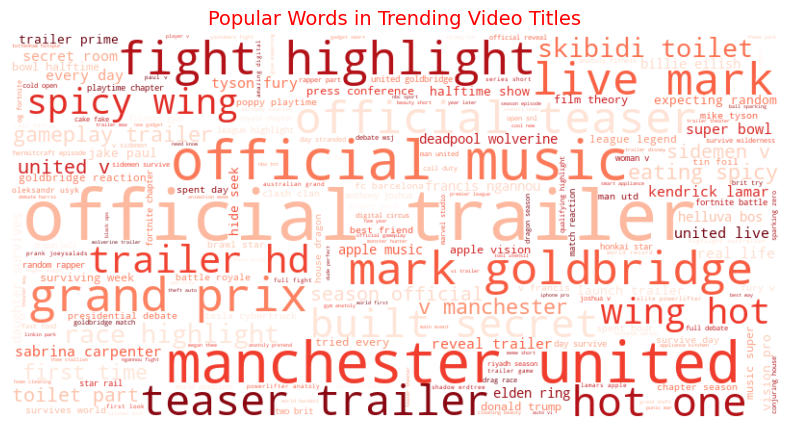

In [27]:
from wordcloud import WordCloud

all_titles = ' '.join(data['processed_title'])

# YouTube-inspired word cloud with red tones
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'  # Red gradient like YouTube's brand color
).generate(all_titles)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Popular Words in Trending Video Titles", fontsize=14, color='red')
plt.show()



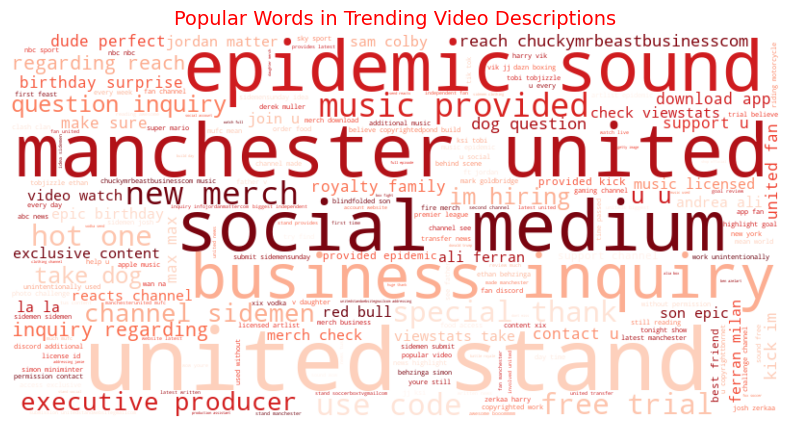

In [28]:
all_descriptions = ' '.join(data['processed_description'])

# YouTube-inspired word cloud with red tones
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'  # Red gradient like YouTube's brand color
).generate(all_descriptions)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Popular Words in Trending Video Descriptions", fontsize=14, color='red')
plt.show()



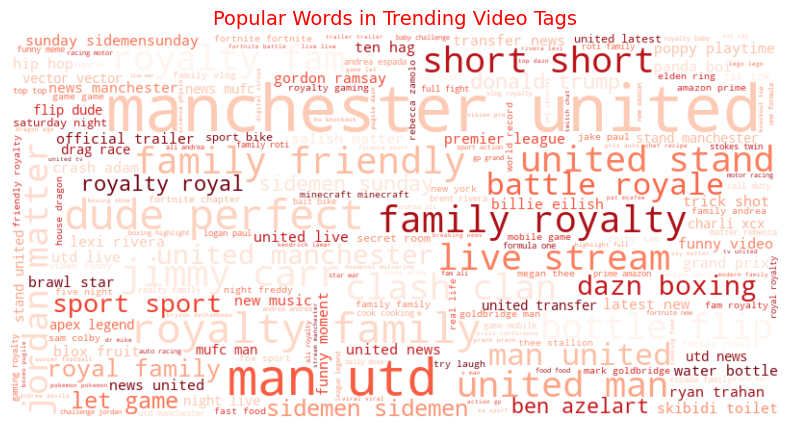

In [29]:
all_tags = ' '.join(data['processed_tags'])

# YouTube-inspired word cloud with red tones
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'  # Red gradient like YouTube's brand color
).generate(all_tags)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Popular Words in Trending Video Tags", fontsize=14, color='red')
plt.show()



### EDA

Plot distribution of 'view_count'

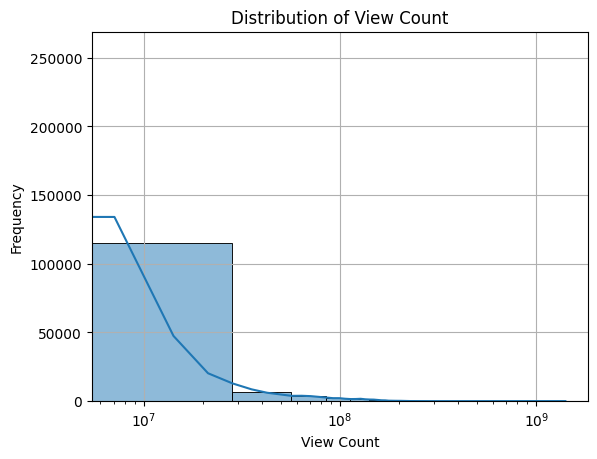

In [30]:
sns.histplot(data['view_count'], bins=50, kde=True)
plt.title('Distribution of View Count')
plt.xlabel('View Count')
plt.ylabel('Frequency')
plt.xscale('log')
plt.grid()
plt.show()


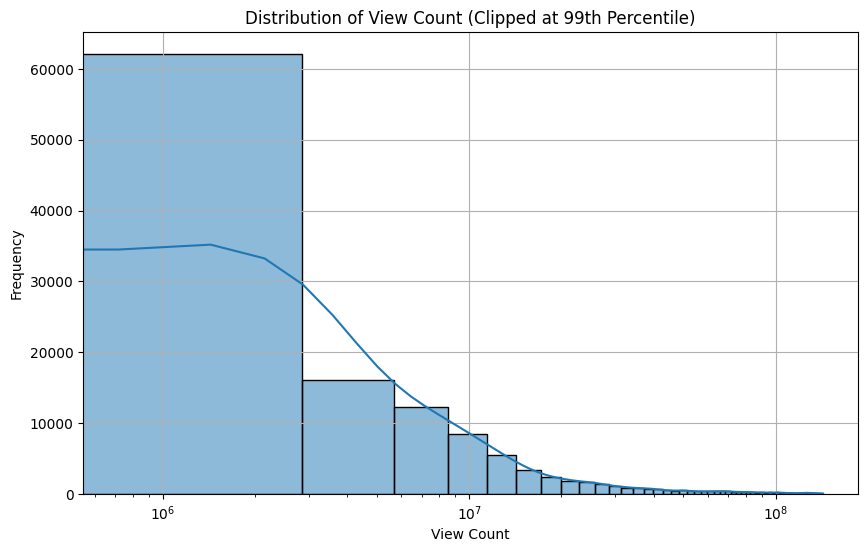

In [31]:
# Clip extreme outliers
percentile_99 = data['view_count'].quantile(0.99)
filtered_data = data[data['view_count'] <= percentile_99]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['view_count'], bins=50, kde=True)
plt.title('Distribution of View Count (Clipped at 99th Percentile)')
plt.xlabel('View Count')
plt.ylabel('Frequency')
plt.xscale('log')
plt.grid()
plt.show()


The distribution is heavily right-skewed with a long tail

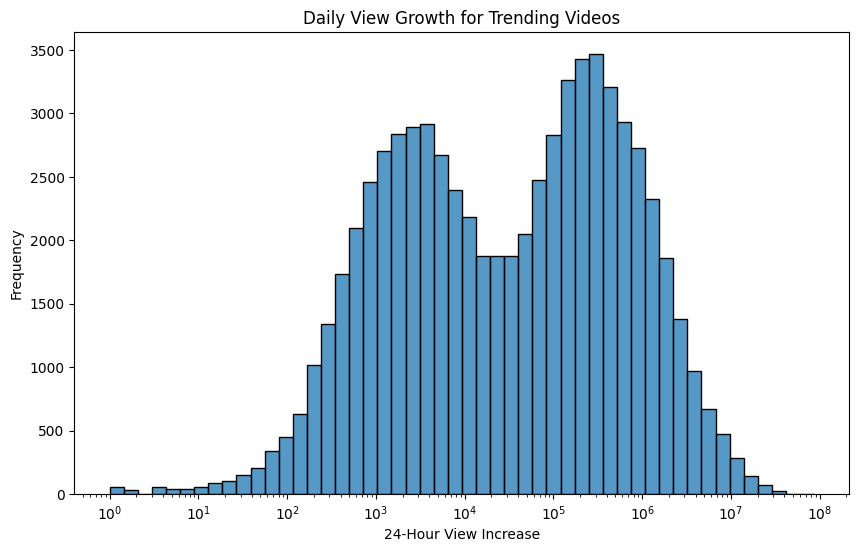

In [32]:
if 'snapshot_date' in data.columns:
    # Group by video_id and calculate view growth
    video_growth = data.sort_values('snapshot_date').groupby('video_id')['view_count'].diff()
    plt.figure(figsize=(10, 6))
    sns.histplot(video_growth.dropna(), bins=50, log_scale=True)
    plt.title('Daily View Growth for Trending Videos')
    plt.xlabel('24-Hour View Increase')
    plt.ylabel('Frequency')
    plt.show()

Most trending videos gain between 100,000 (10^3) and 1,000,000 (10^6) views in a 24-hour period.
The x-axis is logarithmic, showing the wide range of growth rates

### Correlation plot for engagement metrics

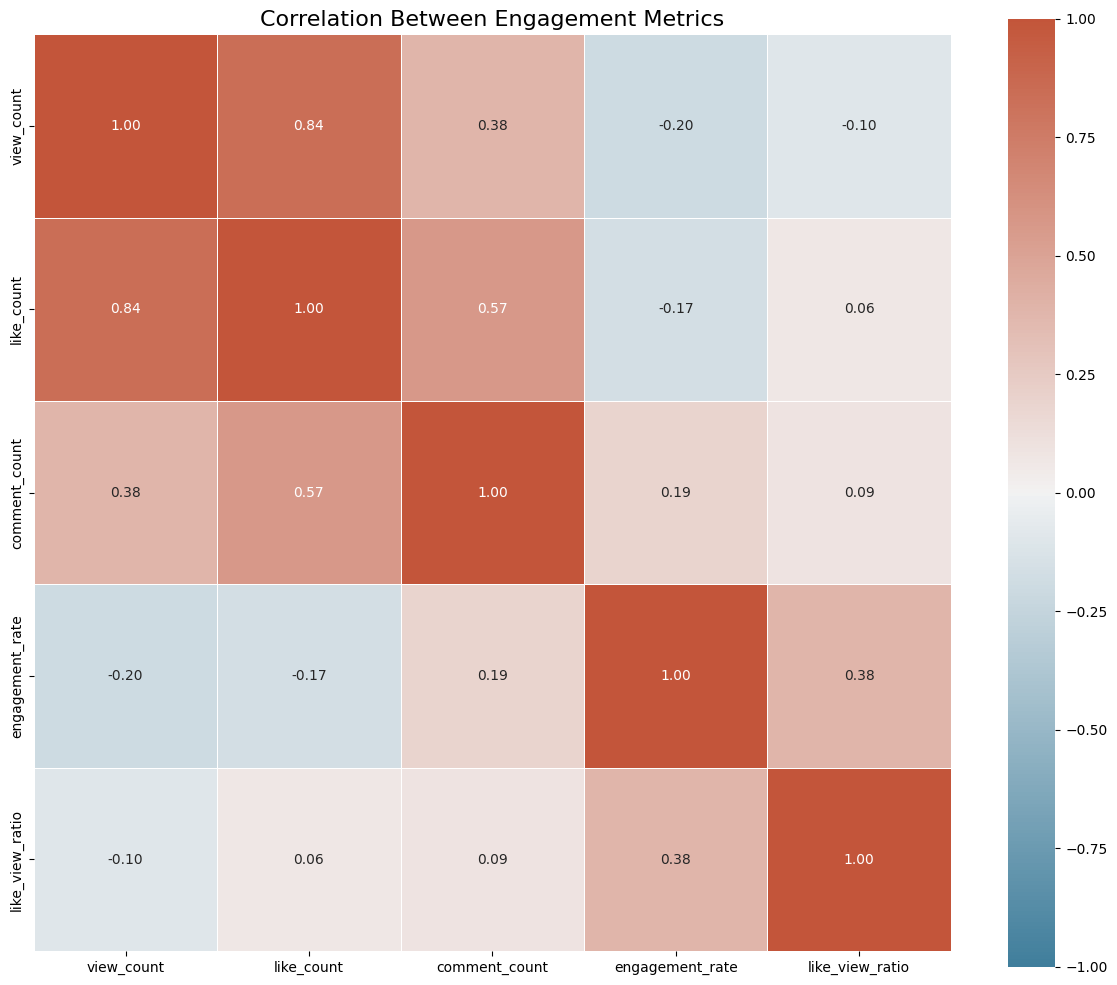

In [33]:
# Create a correlation plot focusing on engagement metrics
plt.figure(figsize=(12, 10))

# Core engagement metrics
engagement_metrics = [
    'view_count', 
    'like_count', 
    'comment_count', 
    'engagement_rate',
    'like_view_ratio'
]

# Create the correlation matrix
corr = data[engagement_metrics].corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt=".2f", square=True, linewidths=.5)

plt.title('Correlation Between Engagement Metrics', fontsize=16)
plt.tight_layout()
plt.show()

### Get top 10 channels by number of trending videos

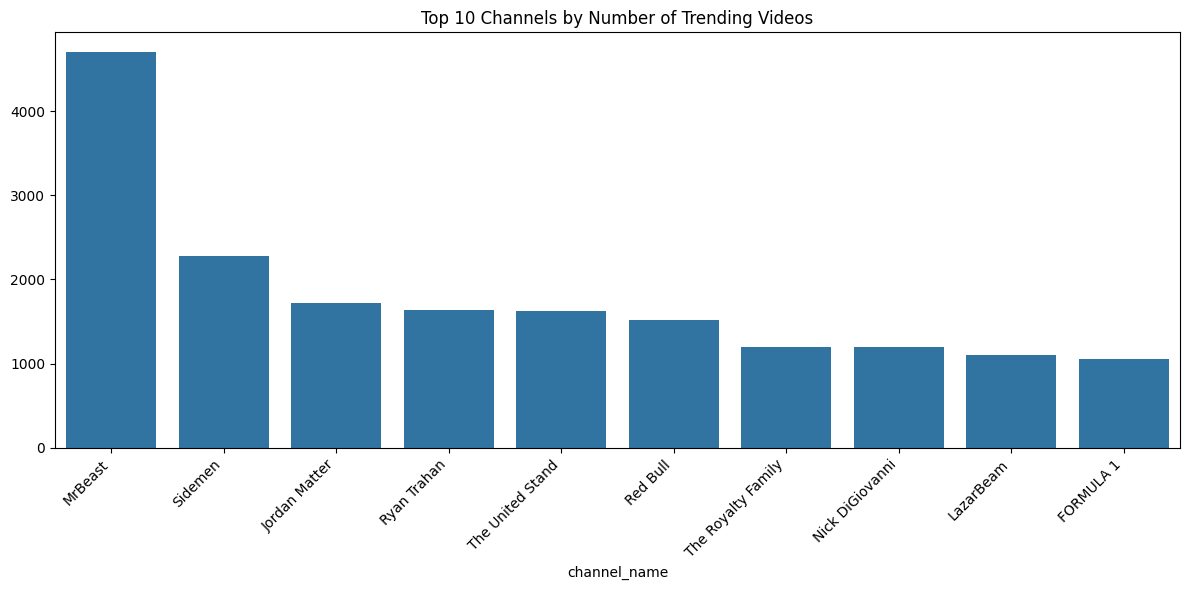

In [34]:
if 'channel_name' in data.columns:
    # Top channels by video count
    plt.figure(figsize=(12, 6))
    channel_counts = data['channel_name'].value_counts().head(10)
    sns.barplot(x=channel_counts.index, y=channel_counts.values)
    plt.title('Top 10 Channels by Number of Trending Videos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Get top categories for historical US dataset

In [ ]:
category_query = """
    SELECT *
    FROM `aesthetic-nova-454803-r7.youtube_trending_dataset.US_trending_videos_transformed`
"""
data = bq_client.query(category_query).to_dataframe(bqstorage_client=bq_storage_client)

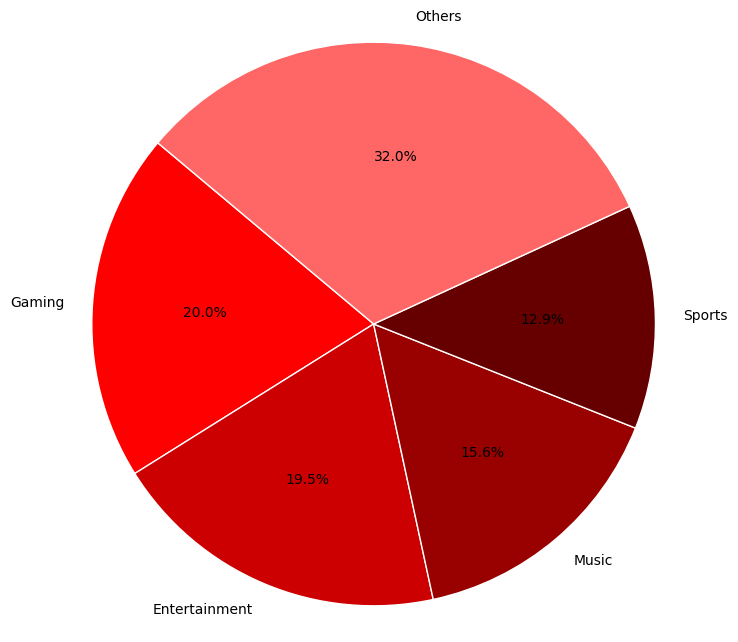

In [ ]:
# Count categories
category_counts = data['categoryId'].value_counts()

# Top 4 + Others
top_categories = category_counts[:4]
others_count = category_counts[4:].sum()
final_counts = pd.concat([top_categories, pd.Series({'Others': others_count})])

colors = ['#FF0000', '#CC0000', '#990000', '#660000', '#FF6666']  # red shades

plt.figure(figsize=(8, 8))
plt.pie(final_counts, 
        labels=final_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white'})

plt.axis('equal')
plt.show()
